In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [49]:
train = pd.read_csv(r'..\data\raw\train.csv', parse_dates=True)
test = pd.read_csv(r'..\data\raw\test.csv', parse_dates=True)

In [6]:
train.head()

,id,user_id,campaign_id,send_date,is_open,is_click
0,42_14051,14051,42,01-09-2017 19:55,0,0
1,52_134438,134438,52,02-11-2017 12:53,0,0
2,33_181789,181789,33,24-07-2017 15:15,0,0
3,44_231448,231448,44,05-09-2017 11:36,0,0
4,29_185580,185580,29,01-07-2017 18:01,0,0


In [16]:
time_df = pd.DataFrame(train[['send_date', 'is_open', 'is_click']])

In [20]:
time_df.set_index(time_df['send_date'], inplace=True)

In [22]:
del(time_df['send_date'])

In [23]:
time_df.head()

,is_open,is_click
send_date,,
01-09-2017 19:55,0,0
02-11-2017 12:53,0,0
24-07-2017 15:15,0,0
05-09-2017 11:36,0,0
01-07-2017 18:01,0,0


In [26]:
time_df.index = pd.to_datetime(time_df.index)

In [45]:
monthly_df = time_df.resample('M').sum() / time_df.resample('M').count()

In [46]:
monthly_df

,is_open,is_click
send_date,,
2017-01-31,0.100855,0.011480
2017-02-28,0.055909,0.014621
2017-03-31,0.131513,0.004767
2017-04-30,NaN,NaN
2017-05-31,0.103111,0.011993
2017-06-30,0.040570,0.011475
2017-07-31,0.167867,0.011739
2017-08-31,0.145928,0.013160
2017-09-30,0.108883,0.015683


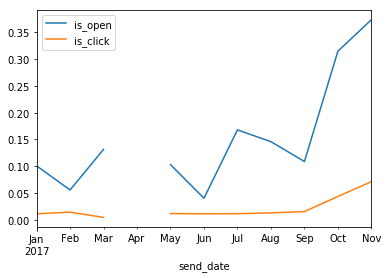

In [47]:
monthly_df.plot();

#### Too less data for identifying monthly trend

### Where did Apr data go?
#### Let's check if the missing data is inserted into test data 

In [50]:
test_time_series = test['id']

In [52]:
test_time_series.index = pd.to_datetime(test['send_date'])

In [53]:
test_time_series = test_time_series.resample('M').count()

In [56]:
test_time_series

send_date
2018-01-31    219250
2018-02-28    196509
2018-03-31         0
2018-04-30         0
2018-05-31    151892
2018-06-30     88366
2018-07-31     65274
2018-08-31      2838
2018-09-30     15428
2018-10-31     12382
2018-11-30      5935
2018-12-31     15984
Freq: M, Name: id, dtype: int64

#### This seems to be not correct. The test data is of future date.

### Let's analyze data by weekdays

In [72]:
time_df['day'] = time_df.index.weekday

In [73]:
time_df.head(10)

,is_open,is_click,day
send_date,,,
2017-01-09 19:55:00,0,0,0
2017-02-11 12:53:00,0,0,5
2017-07-24 15:15:00,0,0,0
2017-05-09 11:36:00,0,0,1
2017-01-07 18:01:00,0,0,5
2017-09-28 15:53:00,0,0,3
2017-01-09 20:13:00,0,0,0
2017-01-09 20:11:00,0,0,0
2017-09-28 15:38:00,0,0,3


In [74]:
time_df.groupby('day')['is_open'].sum() / time_df.groupby('day')['is_open'].count()

day
0    0.098601
1    0.057593
2    0.145718
3    0.153617
4    0.077186
5    0.057456
6    0.072221
Name: is_open, dtype: float64

In [75]:
time_df.groupby('day')['is_click'].sum() / time_df.groupby('day')['is_click'].count()

day
0    0.012131
1    0.014836
2    0.009137
3    0.014127
4    0.014139
5    0.014739
6    0.010771
Name: is_click, dtype: float64

In [76]:
time_df[(time_df['is_open'] == 1)].groupby('day')['is_click'].sum() / time_df[(time_df['is_open'] == 1)].groupby('day')['is_click'].count()

day
0    0.123032
1    0.257591
2    0.062704
3    0.091964
4    0.183178
5    0.256518
6    0.149139
Name: is_click, dtype: float64

### Let's group data by Morning, Afternoon, Evening and Night
##### 6.01-12.00: Morning, 12.01-16.00: Afternoon, 16.01-20.00: Evening, 20.01-6.00: Night

In [90]:
from datetime import datetime, time
def time_of_day(_datetime):
    group = None
    
    if time(6, 1) <= _datetime.time() <= time(12, 0):        
        group = 'Morning'
    elif time(12, 1) <= _datetime.time() <= time(16, 0):        
        group = 'Afternoon'
    elif time(16, 1) <= _datetime.time() <= time(20, 0):        
        group = 'Evening'
    else:        
        group = 'Night'
    
    return group

In [91]:
time_df['time_group'] = time_df.index.map(lambda x: time_of_day(x))

In [92]:
time_df.head(10)

,is_open,is_click,day,time_group
send_date,,,,
2017-01-09 19:55:00,0,0,0,Evening
2017-02-11 12:53:00,0,0,5,Afternoon
2017-07-24 15:15:00,0,0,0,Afternoon
2017-05-09 11:36:00,0,0,1,Morning
2017-01-07 18:01:00,0,0,5,Evening
2017-09-28 15:53:00,0,0,3,Afternoon
2017-01-09 20:13:00,0,0,0,Night
2017-01-09 20:11:00,0,0,0,Night
2017-09-28 15:38:00,0,0,3,Afternoon


In [93]:
time_df.groupby('time_group')['is_open'].sum() / time_df.groupby('time_group')['is_open'].count()

time_group
Afternoon    0.109292
Evening      0.098507
Morning      0.063418
Night        0.102357
Name: is_open, dtype: float64

In [95]:
time_df.groupby('time_group')['is_click'].sum() / time_df.groupby('time_group')['is_click'].count()

time_group
Afternoon    0.013728
Evening      0.012659
Morning      0.011906
Night        0.010939
Name: is_click, dtype: float64

In [96]:
time_df[(time_df['is_open'] == 1)].groupby('time_group')['is_click'].sum() / time_df[(time_df['is_open'] == 1)].groupby('time_group')['is_click'].count()

time_group
Afternoon    0.125610
Evening      0.128510
Morning      0.187734
Night        0.106866
Name: is_click, dtype: float64

#### Both day and time_group seem to be able to add up to discriminating the open and click events. It should be worth considering them for model building 